## Test GPT on Images

After training minGPT using **TorchShard**, we test it on images.

In [1]:
import numpy as np
import torchvision
import torch
import torchshard as ts
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [3]:
# make deterministic
from mingpt.utils import set_seed
set_seed(42)

In [4]:
# pytorch helpfully makes it easy to download datasets, e.g. the common CIFAR-10 https://www.kaggle.com/c/cifar-10
root = './data'
train_data = torchvision.datasets.CIFAR10(root, train=True, transform=None, target_transform=None, download=True)
test_data  = torchvision.datasets.CIFAR10(root, train=False, transform=None, target_transform=None, download=True)
print(len(train_data), len(test_data))

Files already downloaded and verified
Files already downloaded and verified
50000 10000


In [5]:
# get random 5 pixels per image and stack them all up as rgb values to get half a million random pixels
pluck_rgb = lambda x: torch.from_numpy(np.array(x)).view(32*32, 3)[torch.randperm(32*32)[:5], :]
px = torch.cat([pluck_rgb(x) for x, y in train_data], dim=0).float()
print(px.size())

torch.Size([250000, 3])


In [6]:
# run kmeans to get our codebook

# def kmeans(x, ncluster, niter=10):
#     N, D = x.size()
#     c = x[torch.randperm(N)[:ncluster]] # init clusters at random
#     for i in range(niter):
#         # assign all pixels to the closest codebook element
#         a = ((x[:, None, :] - c[None, :, :])**2).sum(-1).argmin(1)
#         # move each codebook element to be the mean of the pixels that assigned to it
#         c = torch.stack([x[a==k].mean(0) for k in range(ncluster)])
#         # re-assign any poorly positioned codebook elements
#         nanix = torch.any(torch.isnan(c), dim=1)
#         ndead = nanix.sum().item()
#         print('done step %d/%d, re-initialized %d dead clusters' % (i+1, niter, ndead))
#         c[nanix] = x[torch.randperm(N)[:ndead]] # re-init dead clusters
#     return c

ncluster = 512
# with torch.no_grad():
#     C = kmeans(px, ncluster, niter=8)
#     torch.save(C, 'c.pt')
    
# assume we have saved C pt at the fisrt time
# then we just load it after that
C = torch.load('c.pt', map_location='cpu')
print(C.size())

torch.Size([512, 3])


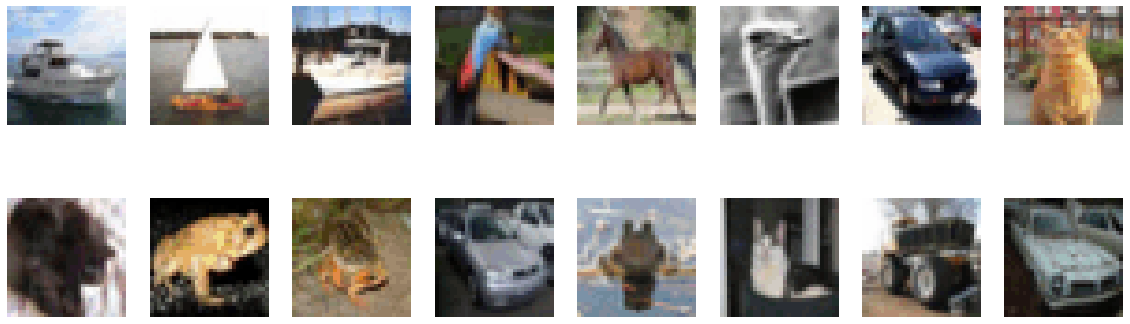

In [7]:
# encode the training examples with our codebook to visualize how much we've lost in the discretization
n_samples = 16
ncol = 8
nrow = n_samples // ncol + 1
plt.figure(figsize=(20, 10))
for i in range(n_samples):
    
    # encode and decode random data
    x, y = train_data[np.random.randint(0, len(train_data))]
    xpt = torch.from_numpy(np.array(x)).float().view(32*32, 3)
    ix = ((xpt[:, None, :] - C[None, :, :])**2).sum(-1).argmin(1) # cluster assignments for each pixel
    
    # these images should look normal ideally
    plt.subplot(nrow, ncol, i+1)
    plt.imshow(C[ix].view(32, 32, 3).numpy().astype(np.uint8))
    plt.axis('off')

The images above look relatively reasonable, so our 512-sized codebook is enough to reasonably re-represent RGB values. Ok cool. So now every image is just a 1024-long sequence of numbers between 0..511. Time to train a GPT.

In [8]:
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    """
    wrap up the pytorch CIFAR-10 dataset into our own, which will convert images into sequences of integers
    """
    
    def __init__(self, pt_dataset, clusters, perm=None):
        self.pt_dataset = pt_dataset
        self.clusters = clusters
        self.perm = torch.arange(32*32) if perm is None else perm
        
        self.vocab_size = clusters.size(0)
        self.block_size = 32*32 - 1
        
    def __len__(self):
        return len(self.pt_dataset)

    def __getitem__(self, idx):
        x, y = self.pt_dataset[idx]
        x = torch.from_numpy(np.array(x)).view(-1, 3) # flatten out all pixels
        x = x[self.perm].float() # reshuffle pixels with any fixed permutation and -> float
        a = ((x[:, None, :] - self.clusters[None, :, :])**2).sum(-1).argmin(1) # cluster assignments
        return a[:-1], a[1:] # always just predict the next one in the sequence

train_dataset = ImageDataset(train_data, C)
test_dataset = ImageDataset(test_data, C)
train_dataset[0][0] # one example image flattened out into integers

tensor([449, 229, 229,  ..., 379,   0, 177])


For reference, **iGPT-S** from the paper is:
- batch size of 128 and trained for 1M terations
- Adam lr 0.003 with betas = (0.9, 0.95)
- learning rate is warmed up for one epoch, then decays to 0
- did not use weight decay or dropout
- `n_layer=24, n_head=8, n_embd=512`

We will do something similar but smaller

In [9]:
from mingpt.model import GPT, GPTConfig, GPT1Config

# we'll do something a bit smaller
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  embd_pdrop=0.0, resid_pdrop=0.0, attn_pdrop=0.0,
                  n_layer=12, n_head=8, n_embd=256,
                  enable_model_parallel=False)
model = GPT(mconf)

04/27/2021 09:42:18 - INFO - mingpt.model -   number of parameters: 1.000166e+07


In [10]:
from mingpt.trainer import Trainer, TrainerConfig

"""
Note that I am running on an 8-GPU V100 machine so each GPU has 32GB.
If you don't have as many computational resources you have to bring down
the batch_size until the model fits into your memory, and then you may
also need to adjust the learning rate (e.g. decrease it a bit). Alternatively,
you can use an even smaller model up above, bringing down the number of layers,
number of heads, and the embedding size.
"""

tokens_per_epoch = len(train_data) * train_dataset.block_size
train_epochs = 20 # todo run a bigger model and longer, this is tiny

# initialize a trainer instance and kick off training
tconf = TrainerConfig(max_epochs=train_epochs, batch_size=32, learning_rate=3e-3,
                      betas = (0.9, 0.95), weight_decay=0,
                      lr_decay=True, warmup_tokens=tokens_per_epoch, final_tokens=train_epochs*tokens_per_epoch,
                      ckpt_path='cifar10_model.pt',
                      num_workers=16)
trainer = Trainer(model, train_dataset, test_dataset, tconf)

# trainer.train() # skip training

In [11]:
# to sample we also have to technically "train" a separate model for the first token in the sequence
# we are going to do so below simply by calculating and normalizing the histogram of the first token
counts = torch.ones(ncluster) # start counts as 1 not zero, this is called "smoothing"
rp = torch.randperm(len(train_dataset))
nest = 5000 # how many images to use for the estimation
for i in range(nest):
    a, _ = train_dataset[int(rp[i])]
    t = a[0].item() # index of first token in the sequence
    counts[t] += 1
prob = counts/counts.sum()

In [12]:
# load the state of the best model we've seen based on early stopping
checkpoint = torch.load('cifar10_model.pt')
model.load_state_dict(checkpoint, strict=False)

<All keys matched successfully>

In [13]:
%%time

from mingpt.utils import sample

n_samples = 32
start_pixel = np.random.choice(np.arange(C.size(0)), size=(n_samples, 1), replace=True, p=prob)
start_pixel = torch.from_numpy(start_pixel).to(trainer.device)
pixels = sample(model, start_pixel, 32*32-1, temperature=1.0, sample=True, top_k=100)

100%|██████████| 1023/1023 [05:33<00:00,  1.19it/s]

CPU times: user 3min 44s, sys: 1min 47s, total: 5min 31s
Wall time: 5min 33s


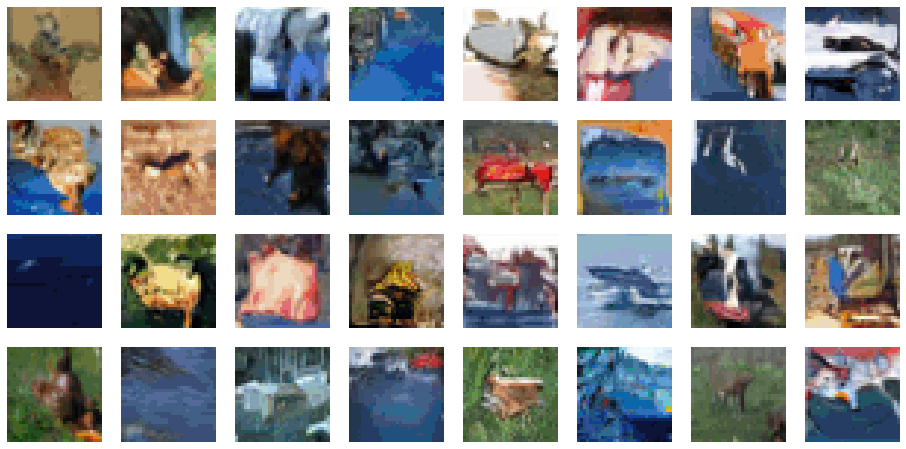

In [14]:
# for visualization we have to invert the permutation used to produce the pixels
iperm = torch.argsort(train_dataset.perm)

ncol = 8
nrow = n_samples // ncol
plt.figure(figsize=(16, 8))
for i in range(n_samples):
    pxi = pixels[i][iperm] # note: undo the encoding permutation
    
    plt.subplot(nrow, ncol, i+1)
    plt.imshow(C[pxi].view(32, 32, 3).numpy().astype(np.uint8))
    plt.axis('off')

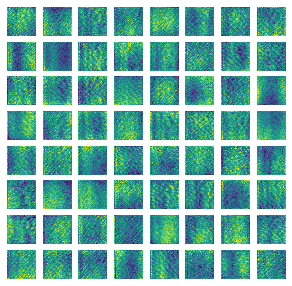

In [15]:
# visualize some of the learned positional embeddings, maybe they contain structure
plt.figure(figsize=(5, 5))
nsee = 8*8
ncol = 8
nrow = nsee // ncol
for i in range(nsee):
    
    ci = model.pos_emb.data[0, :, i].cpu()
    zci = torch.cat((torch.tensor([0.0]), ci)) # pre-cat a zero
    rzci = zci[iperm] # undo the permutation to recover the pixel space of the image
    
    plt.subplot(nrow, ncol, i+1)
    plt.imshow(rzci.view(32, 32).numpy())
    plt.axis('off')

In [16]:
# huh, pretty cool! :P

# TorchShard is not bad! :P